In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import pandas as pd
from typing import Callable
from tqdm import tqdm
import os


pd.options.display.max_columns = 21
pd.options.display.float_format = '{:.2f}'.format
save_results = True
save_figures = False
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [3]:
Card = int
Hand = tuple[int, int, int, int, int, int, int, int, int, int, int, int, int]
Action = int
Policy = Callable[[Hand, Hand], Action]
PlayerPolicy = Callable[[Hand, Card], Action]
Deck = np.ndarray[int]
DeckProb = list[float]

ACE: Card = 1
TWO: Card = 2
THREE: Card = 3
FOUR: Card = 4
FIVE: Card = 5
SIX: Card = 6
SEVEN: Card = 7
EIGHT: Card = 8
NINE: Card = 9
TEN: Card = 10
JACK: Card = 10
QUEEN: Card = 10
KING: Card = 10

card_values: list[Card] = [ACE, TWO, THREE, FOUR, FIVE, SIX, SEVEN, EIGHT, NINE, TEN, JACK, QUEEN, KING]
num_cards: int = len(card_values)
cards: list[int] = list(range(num_cards))

max_card_value: int = max(card_values)
max_score: int = 21

In [4]:
UNKNOWN: Action = 0
HIT: Action = 1
STAND: Action = 2
DOUBLE: Action = 3
SPLIT: Action = 4
SURRENDER: Action = 5

actions_str: dict[Action, str] = {
    UNKNOWN: 'Unknown',
    HIT: 'Hit',
	STAND: 'Stand',
	DOUBLE: 'Double',
	SPLIT: 'Split',
	SURRENDER: 'Surrender',
}

actions_color: dict[Action, str] = {
    UNKNOWN: 'white',
    HIT: 'lightgreen',
	STAND: 'indianred',
	DOUBLE: 'lightblue',
	SPLIT: 'khaki',
	SURRENDER: 'orange',
	np.nan: 'white',
}

In [5]:
def probaDraw(card: Card, deckProb: DeckProb) -> float:
	"""
	Probability of hitting a given card
	"""
	return deckProb[card]

In [6]:
def countScore(ace=0, two=0, three=0, four=0, five=0, six=0, seven=0, eight=0, nine=0, ten=0, jack=0, queen=0, king=0) -> int:
	"""
	Score of some cards
	Each ace is counted as 11 if the total score is less than or equal to 21, otherwise it is counted as 1
	"""
	score = 0
	score += ace * ACE
	score += two * TWO
	score += three * THREE
	score += four * FOUR
	score += five * FIVE
	score += six * SIX
	score += seven * SEVEN
	score += eight * EIGHT
	score += nine * NINE
	score += ten * TEN
	score += jack * JACK
	score += queen * QUEEN
	score += king * KING
	while score <= max_score -10 and ace > 0:
		score += 10
		ace -= 1
	return score

def minScore(ace=0, two=0, three=0, four=0, five=0, six=0, seven=0, eight=0, nine=0, ten=0, jack=0, queen=0, king=0) -> int:
	"""
	Minimum possible score of some cards
	Each ace is counted as 1
	"""
	score = 0
	score += ace * ACE
	score += two * TWO
	score += three * THREE
	score += four * FOUR
	score += five * FIVE
	score += six * SIX
	score += seven * SEVEN
	score += eight * EIGHT
	score += nine * NINE
	score += ten * TEN
	score += jack * JACK
	score += queen * QUEEN
	score += king * KING
	return score

def handScore(hand: Hand) -> int:
	"""
	Score of a hand
	Each ace is counted as 11 if the total score is less than or equal to 21, otherwise it is counted as 1
	"""	
	return countScore(*hand)

def minHandScore(hand: Hand) -> int:
	"""
	Minimum possible score of a hand
	Each ace is counted as 1
	"""
	return minScore(*hand)

def haveAce11(hand: Hand) -> bool:
	"""
	Do we have an ace counted as 11 in a hand
	"""
	return minHandScore(hand) != handScore(hand)

In [7]:
valid_hands_to_index: dict[Hand, int] = {}
idx = 0
for ace in range(0, max_score+1):
	score = minScore(ace)
	for two in range(0, (max_score-score) // TWO +1):
		score = minScore(ace, two)
		for three in range(0, (max_score-score) // THREE +1):
			score = minScore(ace, two, three)
			for four in range(0, (max_score-score) // FOUR +1):
				score = minScore(ace, two, three, four)
				for five in range(0, (max_score-score) // FIVE +1):
					score = minScore(ace, two, three, four, five)
					for six in range(0, (max_score-score) // SIX +1):
						score = minScore(ace, two, three, four, five, six)
						for seven in range(0, (max_score-score) // SEVEN +1):
							score = minScore(ace, two, three, four, five, six, seven)
							for eight in range(0, (max_score-score) // EIGHT +1):
								score = minScore(ace, two, three, four, five, six, seven, eight)
								for nine in range(0, (max_score-score) // NINE +1):
									score = minScore(ace, two, three, four, five, six, seven, eight, nine)
									for ten in range(0, (max_score-score) // TEN +1):
										score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten)
										for jack in range(0, (max_score-score) // JACK +1):
											score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack)
											for queen in range(0, (max_score-score) // QUEEN +1):
												score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen)
												for king in range(0, (max_score-score) // KING +1):
													score = countScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)
													if score <= max_score:
														valid_hands_to_index[(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)] = idx
														idx += 1

num_hands = len(valid_hands_to_index)
index_to_valid_hands: list[Hand] = [None] * num_hands
for hand, idx in valid_hands_to_index.items():
	index_to_valid_hands[idx] = hand

print(f"Number of valid hands: {num_hands}")

Number of valid hands: 3677


In [8]:
def createHand(*args: Card) -> Hand:
	"""
	Create a hand from a list of cards
	Note that 0 correspond to an ace, 1 to a two, 2 to a three, ..., 9 to a ten, 10 to a jack, 11 to a queen and 12 to a king
	"""
	hand = [0] * num_cards
	for card in args:
		hand[card] += 1
	return tuple(hand)

def addCard(hand: Hand, card: Card) -> Hand:
	"""
	Add a card to a hand
	"""
	hand = list(hand)
	hand[card] += 1
	return tuple(hand)

In [9]:
def validHandsFromDeck(deck: Deck) -> list[int]:
	"""
	Hand after drawing a card
	"""
	valid_idx = []
	for ace in range(0, min(deck[0], max_score) +1):
		ace_score = minScore(ace=ace)
		for two in range(0, min(deck[1], (max_score-ace_score) // TWO) +1):
			two_score = minScore(two=two) + ace_score
			for three in range(0, min(deck[2], (max_score-two_score) // THREE) +1):
				three_score = minScore(three=three) + two_score
				for four in range(0, min(deck[3], (max_score-three_score) // FOUR) +1):
					four_score = minScore(four=four) + three_score
					for five in range(0, min(deck[4], (max_score-four_score) // FIVE) +1):
						five_score = minScore(five=five) + four_score
						for six in range(0, min(deck[5], (max_score-five_score) // SIX) +1):
							six_score = minScore(six=six) + five_score
							for seven in range(0, min(deck[6], (max_score-six_score) // SEVEN) +1):
								seven_score = minScore(seven=seven) + six_score
								for eight in range(0, min(deck[7], (max_score-seven_score) // EIGHT) +1):
									eight_score = minScore(eight=eight) + seven_score
									for nine in range(0, min(deck[8], (max_score-eight_score) // NINE) +1):
										nine_score = minScore(nine=nine) + eight_score
										for ten in range(0, min(deck[9], (max_score-nine_score) // TEN) +1):
											ten_score = minScore(ten=ten) + nine_score
											for jack in range(0, min(deck[10], (max_score-ten_score) // JACK) +1):
												jack_score = minScore(jack=jack) + ten_score
												for queen in range(0, min(deck[11], (max_score-jack_score) // QUEEN) +1):
													queen_score = minScore(queen=queen) + jack_score
													for king in range(0, min(deck[12], (max_score-queen_score) // KING) +1):
														king_score = minScore(king=king) + queen_score
														if king_score <= max_score:
															valid_idx.append(valid_hands_to_index[(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)])
	return valid_idx

In [10]:
def checkBlackjack(hand: Hand, score: int=None) -> bool:
	"""
	Check if a hand is a blackjack
	Score is the score of the hand if it is already computed
	"""
	score = score or handScore(hand)
	return handScore(hand) == max_score and sum(hand) == 2

def couldBlackJack(hand: Hand) -> bool:
	"""
	Check if a hand could be a blackjack
	"""
	match sum(hand):
		case 0:
			return True
		case 1:
			return hand[0] == 1 or hand[9] == 1 or hand[10] == 1 or hand[11] == 1 or hand[12] == 1
		case 2:
			return handScore(hand) == max_score
		case _:
			return False

def handComparisonDealerPOV(dealer_hand: Hand, player_hand: Hand) -> float:
	"""
	Compare two valid hands
	Return 1 if the dealer wins, 0 if it is a draw and -1 if the player wins
	Check if there is a blackjack for the dealer and the player
	"""
	sd = handScore(dealer_hand)
	sp = handScore(player_hand)
	dealer_blackjack = checkBlackjack(dealer_hand, sd)
	player_blackjack = checkBlackjack(player_hand, sp)
	assert sd <= max_score and sp <= max_score
	if dealer_blackjack and player_blackjack:
		return 0
	elif dealer_blackjack:
		return 1
	elif player_blackjack:
		return -1.5
	elif sd > sp:
		return 1
	elif sd < sp:
		return -1
	else:
		return 0
 

In [11]:
def updateDeckProb(deck: Deck) -> DeckProb:
	"""
	Update the probability of drawing a card
	"""
	if sum(deck) <= 0:
		return [0] * num_cards
	deckProb: DeckProb = [0] * num_cards
	for card in cards:
		deckProb[card] = deck[card] / sum(deck)
	return deckProb

In [12]:
def probaHit(hand: Hand, deck: Deck) -> float:
	"""
	Probability of hitting and not bursting
	"""
	deckProb = updateDeckProb(deck)
	return sum(probaDraw(card, deckProb) for card in cards if addCard(hand, card) in valid_hands_to_index and deck[card] > 0)

def probaHitList(hand: Hand, deck: Deck) -> list[Hand, float]:
	"""
	Compute the score and the probability of hitting for each card that do not burst the score
	"""
	deckProb = updateDeckProb(deck)
	return [(addCard(hand, card), probaDraw(card, deckProb)) for card in cards if addCard(hand, card) in valid_hands_to_index and deck[card] > 0]

In [13]:
def probaBurst(hand: Hand, deck: Deck) -> float:
	"""
	Probability of bursting
	"""
	return 1 - probaHit(hand, deck)

def probaBurstList(hand: Hand, deck: Deck) -> list[Hand, float]:
	"""
	Compute the score and the probability of bursting for each card that burst the score
	"""
	deckProb = updateDeckProb(deck)
	return [(addCard(hand, card), probaDraw(card, deckProb)) for card in cards if handScore(hand) + card_values[card] > max_score and deck[card] > 0]

In [14]:
def getDealerGainMatrix(policy: Policy, hand_player: Hand, deck: Deck) -> np.ndarray:
	"""
	Compute the gain matrix for the dealer optimal policy
	It consider that only 2 actions are possible: hit or stand
	"""
	gainMatrix = np.zeros(num_hands)
	for hand_dealer_idx in range(num_hands-1, -1, -1):
		hand_dealer = index_to_valid_hands[hand_dealer_idx]
		hand_dealer_numpy = np.array(hand_dealer)
		deck -= hand_dealer_numpy
		if (deck < 0).any():
			gainMatrix[hand_dealer_idx] = np.nan
			deck += hand_dealer_numpy
			continue
		action = policy(hand_player, hand_dealer)

		if action == HIT:
			hit_score = 0
			for new_hand, proba in probaHitList(hand_dealer, deck):
				hit_score += proba * gainMatrix[valid_hands_to_index[new_hand]]
			burst_score = probaBurst(hand_dealer, deck)
			gainMatrix[hand_dealer_idx] = hit_score - burst_score
		elif action == STAND:  
			gainMatrix[hand_dealer_idx] = handComparisonDealerPOV(hand_dealer, hand_player)

		deck += hand_dealer_numpy
	return gainMatrix

In [15]:
def getGainMatrixPlayerOptimalPolicy(dealer_policy, deck: Deck) -> np.ndarray:
	"""
	Compute the gain matrix for the player optimal policy
	It consider that 2 actions are possible: hit or stand
	The player policy is also computed and returned
	"""
	gainMatrix = np.zeros((num_hands, num_cards))
	policyMatrix = np.zeros((num_hands, num_cards))
	dealerGainDict = {}
	for hand_player_idx in range(num_hands-1, -1, -1):
		hand_player = index_to_valid_hands[hand_player_idx]
		for card_dealer in cards:
			hand_dealer = createHand(card_dealer)
			hand_dealer_idx = valid_hands_to_index[hand_dealer]
			hand_player_array = np.array(hand_player)
			deck -= hand_player_array
			deck[card_dealer] -= 1
			if (deck < 0).any():
				gainMatrix[hand_player_idx, card_dealer] = np.nan
				deck += hand_player_array
				deck[card_dealer] += 1
				continue
			hit_score = 0
			for new_hand, proba in probaHitList(hand_player, deck):
				hit_score += proba * gainMatrix[valid_hands_to_index[new_hand], card_dealer]
			hit_score -= probaBurst(hand_player, deck)
			
			deck[card_dealer] += 1
			if hand_player in dealerGainDict:
				stand_score = -(dealerGainDict[hand_player])[hand_dealer_idx]
			else:
				dealerGainDict[hand_player] = getDealerGainMatrix(dealer_policy, hand_player, deck)
				stand_score = -(dealerGainDict[hand_player])[hand_dealer_idx]
			gainMatrix[hand_player_idx, card_dealer] = max(hit_score, stand_score)
			policyMatrix[hand_player_idx, card_dealer] = HIT if hit_score >= stand_score else STAND
			deck += hand_player_array
	return gainMatrix, policyMatrix

In [16]:
def standOn17Hard(player_hand: hand, dealer_hand: hand) -> Action:
	"""
	Dealer stand on 17 hard
	"""
	return STAND if handScore(dealer_hand) >= 17 else HIT

In [17]:
def standOn17Soft(player_hand: Hand, dealer_hand: Hand) -> Action:
	"""
	Dealer stand on 17 soft
	"""
	return HIT if handScore(dealer_hand) < 17 or (haveAce11(dealer_hand) and handScore(dealer_hand) == 17) else STAND

In [18]:
if os.path.exists("data/dealerPolicyOptimal.npy"):
	optimalDealerPolicyMatrix = np.load("data/dealerPolicyOptimal.npy")
else:
    raise ValueError("Dealer optimal policy not found. Try to run the script of Q1 first with option 'save_results = True'.")

In [19]:
def dealerOptimalPolicy(player_hand: Hand, dealer_hand: Hand) -> Action:
	"""
	Dealer optimal policy
	"""
	return optimalDealerPolicyMatrix[valid_hands_to_index[player_hand], valid_hands_to_index[dealer_hand]]

On peut faire un test (rapide) avec très peu de cartes

In [20]:
deck = np.array([1] * num_cards)
playerGainMatrix, playerPolicyMatrix = getGainMatrixPlayerOptimalPolicy(standOn17Soft, deck)

In [21]:
def computePlayerGlobalGain(playerGainMatrix: np.ndarray, deck: Deck) -> float:
	"""
	Compute the global gain for the player
	"""
	gain = 0
	for card1_player in card_values:
		for card2_player in card_values:
			for card_dealer in cards:

				proba = probaDraw(card1_player, deckProb=updateDeckProb(deck))
				deck[card1_player] -= 1
				if (deck < 0).any():
					deck[card1_player] += 1
					continue
 
				proba *= probaDraw(card2_player, deckProb=updateDeckProb(deck))
				deck[card2_player] -= 1
				if (deck < 0).any():
					deck[card1_player] += 1
					deck[card2_player] += 1
					continue
 
				proba *= probaDraw(card_dealer, deckProb=updateDeckProb(deck))
				deck[card_dealer] -= 1
				if (deck < 0).any():
					deck[card1_player] += 1
					deck[card2_player] += 1
					deck[card_dealer] += 1
					continue
 
				gain += playerGainMatrix[valid_hands_to_index[createHand(card1_player, card2_player)], card_dealer] * proba
				deck[card1_player] += 1
				deck[card2_player] += 1
				deck[card_dealer] += 1
	return gain

In [22]:
print(f"Player global gain: {computePlayerGlobalGain(playerGainMatrix, deck)}")

Player global gain: -0.12330605351438641


In [ ]:
compute_gain = False

decks = [np.array([1] * num_cards),
		 np.array([2] * num_cards),
		 np.array([3] * num_cards),
		 np.array([4] * num_cards),
		 np.array([8] * num_cards),
		 np.array([7 * 4] * num_cards)]
if compute_gain:
	for dealer_policy in [standOn17Soft, standOn17Hard, dealerOptimalPolicy]:
		for deck in decks:
			new_deck = deck.copy()
			playerGainMatrix, _ = getGainMatrixPlayerOptimalPolicy(dealer_policy, new_deck)            
			gain = computePlayerGlobalGain(playerGainMatrix, new_deck)
			print(f"Policy: {dealer_policy.__name__}, Gain: {gain}, Deck: {deck}")

In [ ]:
def simulate_global_gain_boxplot(num_simulations, num_sets=1, save_fig=False, save_results=False):
    decks = [np.random.randint(0, num_sets * 4 + 1, num_cards) for _ in range(num_simulations)]
    policies = [dealerOptimalPolicy, standOn17Soft, standOn17Hard]
    gains_by_policy = {policy.__name__: [] for policy in policies}
    
    with tqdm(total=num_simulations * len(policies), desc="Simulations") as pbar:
        for dealer_policy in policies:
            for deck in decks:
                new_deck = deck.copy()
                playerGainMatrix, _ = getGainMatrixPlayerOptimalPolicy(dealer_policy, new_deck)            
                gain = computePlayerGlobalGain(playerGainMatrix, new_deck)
                gains_by_policy[dealer_policy.__name__].append(gain)
                pbar.update(1)

    plt.figure(figsize=(12, 8))
    policy_names = list(gains_by_policy.keys())
    gain_values = list(gains_by_policy.values())

    colors = ['lightblue', 'lightgreen', 'lightcoral']
    box = plt.boxplot(gain_values, patch_artist=True, notch=True, vert=True, widths=0.7,
                      labels=policy_names, showmeans=True, meanline=True)
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    for i, policy in enumerate(policy_names):
        data = gains_by_policy[policy]
        min_val, max_val = np.min(data), np.max(data)
        mean_val, median_val = np.mean(data), np.median(data)
        
        plt.text(i + 1, min_val - 0.009, f"Min: {min_val:.2f}", ha='center', color='blue', fontsize=12)
        plt.text(i + 1, max_val + 0.002, f"Max: {max_val:.2f}", ha='center', color='red', fontsize=12)
        dec_mean = 0.002 if mean_val > median_val else -0.009
        dec_median = -0.009 if mean_val > median_val else 0.002
        plt.text(i + 1, mean_val + dec_mean, f"Mean: {mean_val:.2f}", ha='center', color='black', fontsize=13)
        plt.text(i + 1, median_val + dec_median, f"Median: {median_val:.2f}", ha='center', color='black', fontsize=13)
    
    plt.title("Global Gain Distribution by Dealer Policy")
    plt.ylabel("Gain")
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    if save_fig:
        plt.savefig("images/global_gain_boxplot.png", format="png")
        
    if save_results:
        with open("data/global_gain_boxplot.txt", "a+") as f:
            f.write(f"Global Gain Distribution by Dealer Policy\n")
            f.write(f"Number of simulations: {num_simulations}\n")
            f.write(f"Number of sets: {num_sets}\n")
            for policy, gains in gains_by_policy.items():
                f.write(f"{policy}: {gains}\n")
    plt.show()

Simulations: 100%|██████████| 30/30 [04:08<00:00,  8.29s/it]


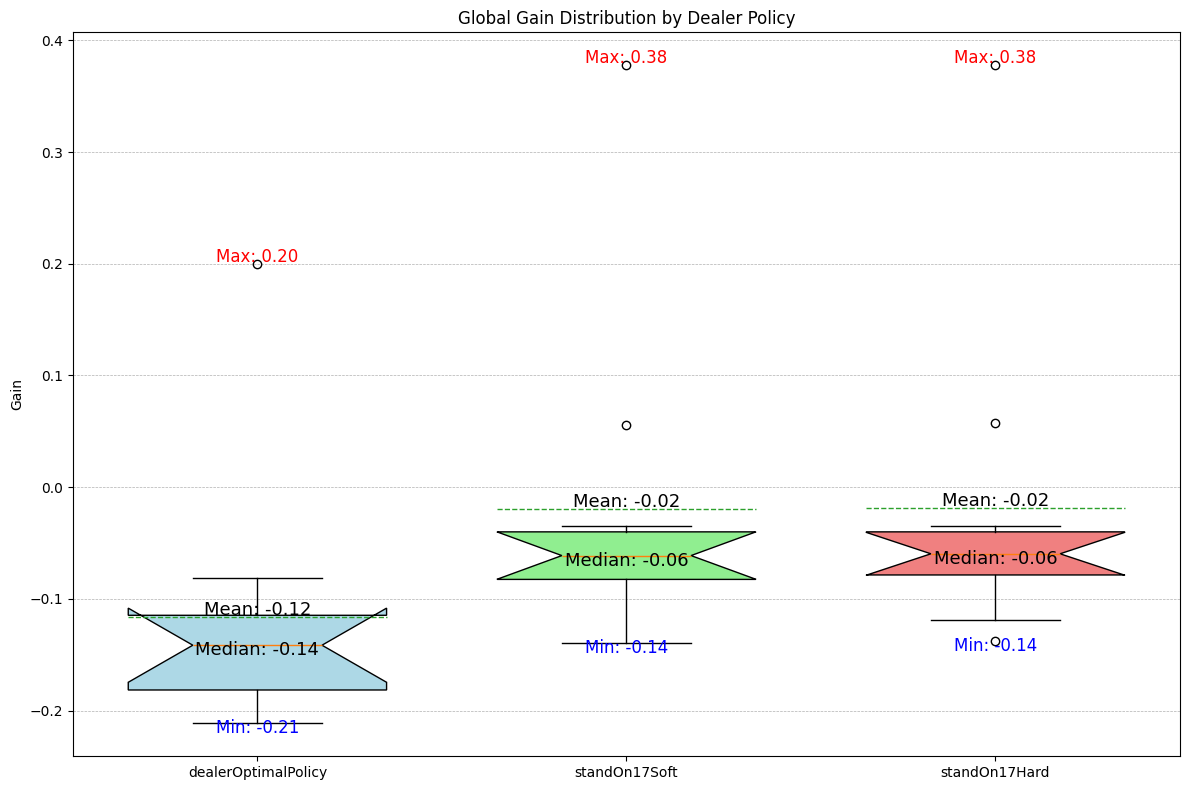

In [ ]:
num_simulations = 50
num_sets = 7
simulate_global_gain_boxplot(num_simulations, num_sets, save_fig=save_figures, save_results=save_results)